# Fifth Project: Data flow Analysis & Optimizations

In this fifth project, you will do some analysis and optimizations of the MJIR. After
building the CFG for each function in the program, you should perform some basic
optimizations, such as constant propagation, constant folding and elimination of
dead code, as described in the following sections.

After performing these optimizations, you can simplify the CFG by:
 - merging consecutive blocks in which the father has one child, the child one parent and both have compatible instructional leaders;
 - finding all immediate dead blocks and remove them, and finally
 - removing unused allocations.

This simplification of the CFG is optional, but recommended. We will try to give
you a hand by giving you some of the pieces prewritten and littered your code
with helpful statements. By the time you are done, you will have a pretty thorough
understanding of the analyses and optimizations realized by real compilers.

## DataFlow Analysis

### Reaching Definitions
Reaching definitions is one of the most common and useful dataflow analysis. By knowing
where in a program each variable ```x``` may have been defined when control reaches each
point ```p```, we can determine many things about ```x```. For just one example, a
compiler then knows whether ```x``` is a ```constant``` at point ```p```.

We say a definition ```d``` reaches a point ```p``` if there is a path from the point
immediately following ```d``` to ```p```, such that ```d``` is not "killed" along
that path. We kill a definition of a variable ```x``` if there is any other definition
of ```x``` anywhere along the path. Intuitively, if a definition ```d``` of some
variable ```x``` reaches point ```p```, then ```d``` might be the place at which the
value of ```x``` used at ```p``` was last defined.

A definition of a variable ```x``` is a statement that assigns a value to ```x```. For
the sake of simplicity, assume that we are dealing only with variables without any aliases.

**Iterative Algorithm for Reaching Definitions**

For a generic instruction, we define the GEN and KILL sets as follows:

  - GEN [$d:y \leftarrow f(x_{1},\cdots ,x_{n})]=\{d\}$, a set of locally available
  definitions in a basic block
  
  - KILL [$d:y \leftarrow f(x_{1},\cdots ,x_{n})]=$ DEFS$[y]-\{d\}$, a set of definitions
  (not locally available, but in the rest of the program) killed by definitions in the
  basic block.
  
where DEFS[y] is the set of all definitions that assign to the variable y. Here d is a
unique label attached to the assigning instruction; thus, the domain of values in reaching
definitions are these instruction labels.

We assume that every control-flow graph has an ENTRY node, which represents the starting
point of the graph, and an EXIT node to which all exits out of the graph go. Since no
definitions reach the beginning of the graph, the transfer function for the ENTRY block
is a simple constant function that returns $\phi$ as an answer.

The reaching definitions problem is defined by the following equations:

OUT[ENTRY] = $\phi$

and for all basic blocks B other than ENTRY,

$OUT[B] = gen_{B} \bigcup\ (IN[B] - kill_{B})$

$IN[B] = \bigcup_{p\ a\ predecessor\ of\ B} OUT[P]$

These equations can be solved using the following algorithm:
```c
// Initialize
for all CFG block b in B,  
  OUT[b] = emptyset;

// put all blocks into the changed set
// B is all blocks in graph,
Changed = B;

//Iterate
while (Changed != emptyset)
{
  choose a block b in Changed;
  // remove it from the changed set
  Changed = Changed - { b };

  // init IN[b] to be empty
  IN[b] = emptyset;  

  // calculate IN[b] from predecessors' OUT[p]
  for all blocks p in predecessors(b)
     IN[b] = IN[b] Union OUT[p];

  oldout = OUT[b]; // save old OUT[b]
  
  // update OUT[b] using transfer function f_b ()
  OUT[b] = GEN[b] Union (IN[b] - KILL[b]);   

  // any change to OUT[b] compared to previous value?
  if (OUT[b] changed) // compare oldout vs. OUT[b]
  {  
    // if yes, put all successors of b into the changed set
    for all blocks s in successors(b)
       Changed = Changed U { s };  
  }
}
```

### Liveness Analysis
Liveness analysis is a data flow analysis that finds what variables are live after any
statement. It is an any-path, backward flow analysis. We will perform intra-procedural
liveness analysis (i.e., we will compute liveness at the function granularity, but not
across functions).

Once you have built the CFG, liveness analysis is easy. Compute the GEN and KILL sets for
each block. GEN represents all the temporaries and variables that are used in an
instruction, and KILL represents all the temporaries and variables that are defined in
an instruction. For most instructions, this should be pretty straightforward. A few
tricky cases:

  - ```store_type``` this instruction use source (GEN) & define target (KILL)
  while ```store_type_*```use both source & target. Note that this strategy means that you do not touch the
    ```alloc_type``` instructions. An extra pass can be made at final to remove unused
     allocs.
  - ```call``` instructions require special care. Because we do not analyze liveness
  across functions, we must make conservative assumptions about what happens in function
  calls. In particular, we GEN all the temporaries in ```param_type```. The ```call```
  itself kills the return var. The GEN set for any ```call``` instruction therefore
  contains all global variables, while the KILL set is their return var.

Once you know the GEN and KILL sets for each CFG node, you can compute liveness. To do
this, define IN (live-in) and OUT (live-out) sets for each CFG Node. Initialize the OUT
sets for Exit nodes to all global variables (because global variables may be used after
the function returns), and initialize all other sets to empty. Then compute the live-in
and live-out sets for node as follows:

  - The set of variables that are live out of a node is the union of all the variables
  that are live in to the node's successors.
  - The set of variables that are live in to a node is the set of variables that are live
  out for the node, minus any variables that are killed by the node, plus any variables
  that are gen-ed by the node.
  
Note that these definitions are recursive: the live-out set of a node is defined in
terms of the live-in sets of its successors, which are in turn defined in terms of the
live-in sets of their successors, and so on. If there is a loop in the code, then the
definition seems circular.

The trick to computing liveness is to compute a fixpoint: assignments to each of the
live-in and live-out sets so that if you try to compute any node's live-in or live-out
set again, you will get the same result you already have. To do this, we will use a worklist
algorithm:

  1. Put all the IR nodes on the worklist
  2. Pull an IR node off the worklist, and compute its live-out and live-in sets according
   to the definitions above.
  3. If the live-in set of the node gets updated by the previous step, put all of the
  node's predecessors on the worklist (because they may need to update their live-out sets).
  4. Repeat steps 2 and 3 until the worklist is empty. The live-out sets of each node
  now represent a fixpoint.

## Constant Propagation
Constants assigned to a variable can be propagated through the flow graph and substituted
at the use of the variable.

Example:
In the code fragment below, the value of x can be propagated to the use of x.
```c
int x = 14;
int y = 7 - x / 2;
return y * (28 / x + 2);
```  
Below is the code fragment after ```constant propagation``` and ```constant folding```
(which would likely be further optimized by ```dead code elimination``` of both x and y).
```c
int x = 14;
int y = 0;
return 0;
```  
Constant propagation is implemented in compilers using ```reaching definition``` analysis
results. If all variable's reaching definitions are the same assignment which assigns a
same constant to the variable, then the variable has a constant value and can be replaced
with the constant.

Constant propagation can also cause conditional branches to simplify to one or more
unconditional statements, when the conditional expression can be evaluated to true or
false at compile time to determine the only possible outcome.

## Dead Code Elimination
Code that is unreachable or that does not affect the program (e.g. dead stores) can be
eliminated.

Example:
In the example below, the value assigned to it is never used, and the dead store can be
eliminated. The first assignment to global is dead, and the third assignment to global
is unreachable; both can be eliminated.

```java
class Program {
    int global;
    public void f ()
    {
        int i;
        i = 1;               /* dead store */
        this.global = 1;     /* dead store */
        this.global = 2;
        return;
        this.global = 3;     /* unreachable */
    }
}
```

Below is the code fragment after dead code elimination.

```java
class Program {
    int global;
    void f ()
    {
        this.global = 2;
        return;
    }
}
```

## Examples
```java
class Program {
    public static void main(String[] args) {
        int i = 3, n = 6;
        for (int k = 1; k < n; k=k+1) {
            if (i >= n) {
                break;
            }
            else {
                i=i+1;
            }
        }
        assert i == n;
    }
}
```

CFG before optimization:

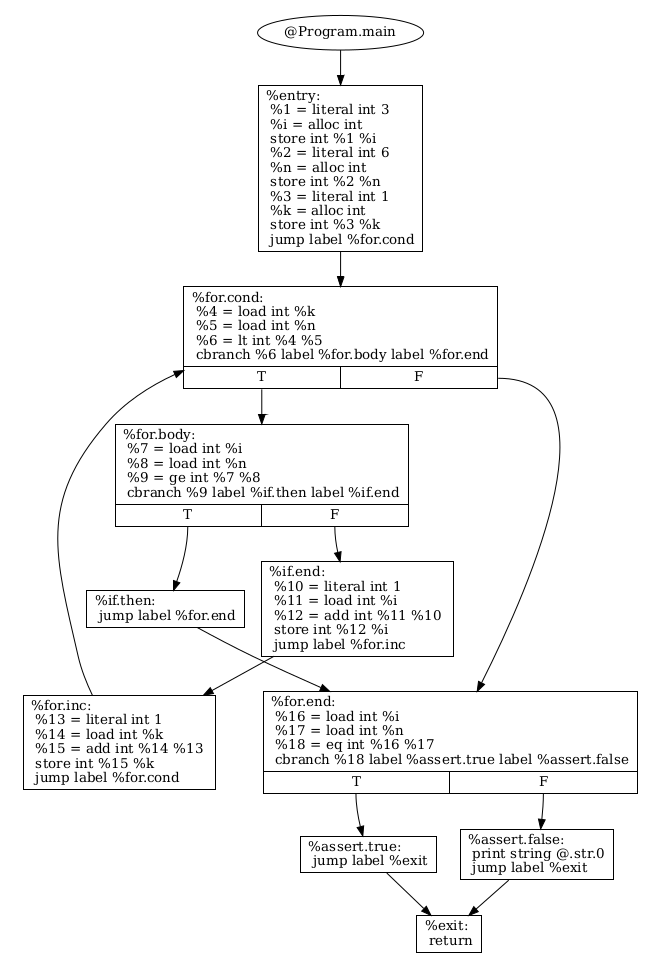

CFG after optimization:

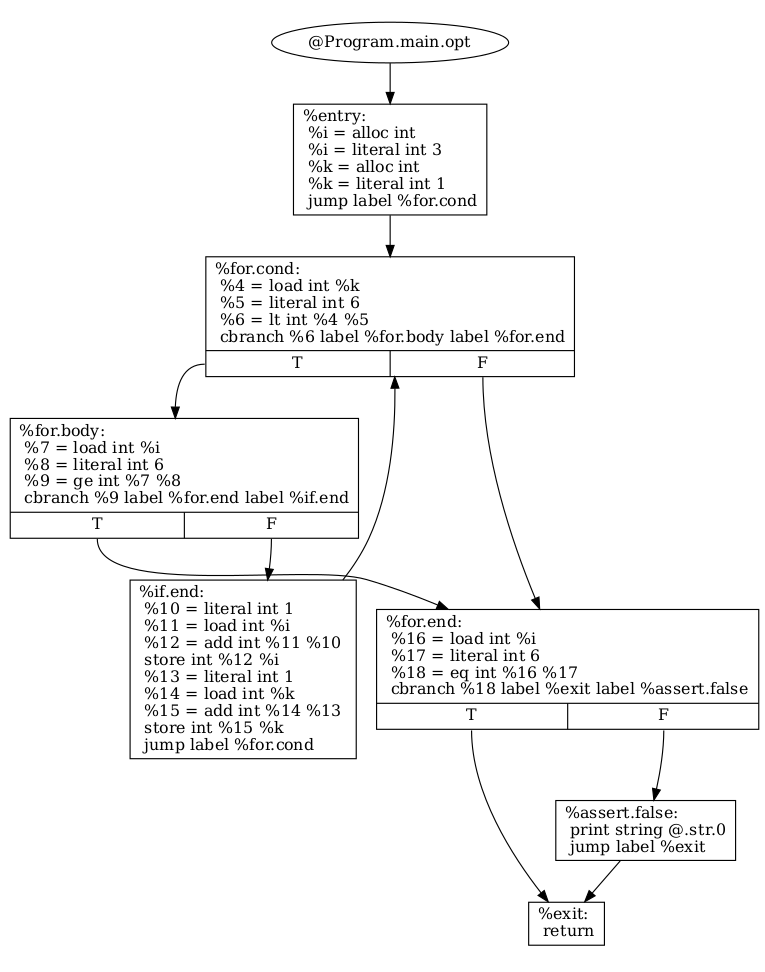

```java
class Program {
    public static void main(String[] args) {
        int x, y;
        x = 1;
        y = 1;
        print(x);
        if (y > 1) {
            x = 2;
        }
        print(x);
    }
}
```

CFG before optimization:


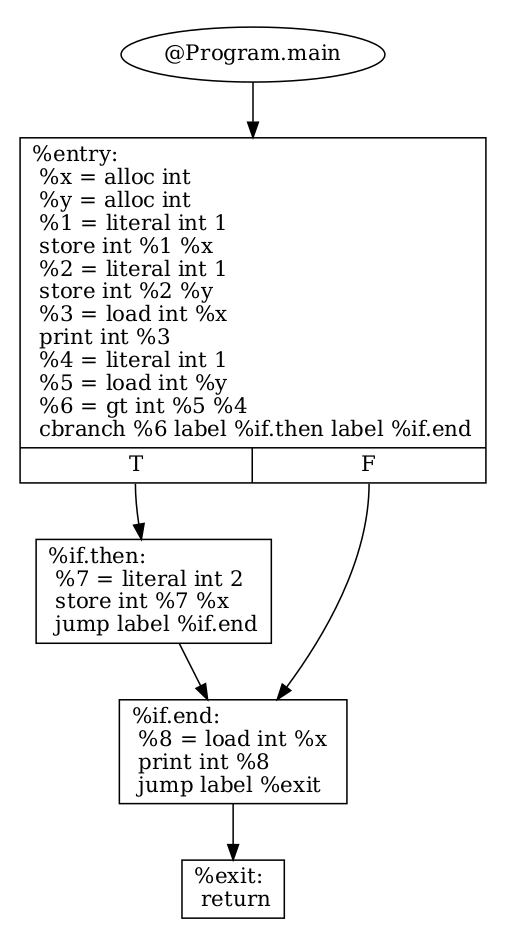

CFG after optimization:

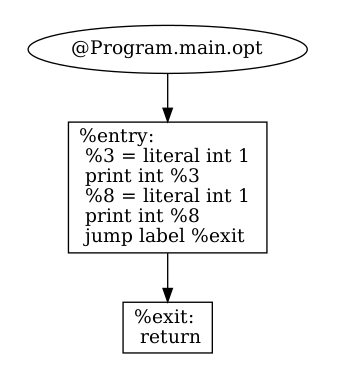

# Performing Analysis & Optimizations

As you may have noted, we kept the CFG built for each method as an attribute of the ```MethodDecl``` node in the AST. This is not the traditional approach: we could have built a new object which would represent the IR of the whole program apart from AST, since we no longer depend on it. But we decided to reuse the AST to avoid creating yet another data-structure. As a result, the method below visit the ```method_decls``` nodes from the ```class_decls``` in the root node (```Program```) to have access to the CFGs of the functions in order to perform the analyzes and apply the optimizations.

In [ ]:
class DataFlow(NodeVisitor):
    def __init__(self, viewcfg):
        # flag to show the optimized control flow graph
        self.viewcfg = viewcfg
        # list of code instructions after optimizations
        self.code = []
        ...

    def show(self):
        _str = ""
        for _code in self.code:
            _str += format_instruction(_code) + "\n"
        rich.print(_str.strip())

    ...

    def visit_Program(self, node: Program):
        # First, save the global instructions on code member
        self.code = node.text[:]  # [:] to do a copy

        # Visit all class declaration in the program
        for class_decl in node.class_decls:
            self.visit(class_decl)

    def visit_ClassDecl(self, node: ClassDecl):
        bb = EmitBlocks()
        bb.visit(node.cfg)
        for _code in bb.code:
            if "class" in _code[0] or "field" in _code[0]:
                self.code.append(_code)

        for method_decl in node.method_decls:
            self.current_func = method_decl
            # start with Reach Definitions Analysis
            self.buildRD_blocks(method_decl.cfg)
            self.computeRD_gen_kill()
            self.computeRD_in_out()
            # and do constant propagation optimization
            self.constant_propagation()

            # after do live variable analysis
            self.buildLV_blocks(method_decl.cfg)
            self.computeLV_use_def()
            self.computeLV_in_out()
            # and do dead code elimination
            self.deadcode_elimination()

            # after that do cfg simplify (optional)
            self.short_circuit_jumps(method_decl.cfg)
            self.merge_blocks(method_decl.cfg)
            self.discard_unused_allocs(method_decl.cfg)

            # finally save optimized instructions in self.code
            self.appendOptimizedCode(method_decl.cfg)

        if self.viewcfg:
            for method_decl in node.method_decls:
                method_name = getattr(method_decl, "name", None)
                if method_name is not None:
                    method_name = method_name.name
                else:
                    method_name = "main"

                dot = CFG(f"@{node.name.name}.{method_name}.opt")
                dot.view(method_decl.cfg)

    # TODO: add dataflow analysis

# A note on the evaluation

We will award points based on the performance of the code in this step. Unlike the
previous step, in which we evaluate the correctness of the execution, in this step, we
will award points based on the least amount of instructions from the MJIR. In other
words, teams that do a better job of optimizing will receive more points. The
*main module* (```mjc/mj_compiler.py```) is programmed to print the number of instructions before and
after optimization when the '-o' flag is used.